# Algal Bloom Detection
## or
# Earth Observation and Data Science: data preparation

### Example how to:

* Reproject spatial data;
* Clean scenes from the clouds;
* Detect harmful algal blooms based on the Landsat 8 data and literature review.

Steps to achieve results:
1. Import Python libraries and functions.
2. Prepare time series Data Frame with Landsat 8 scenes (class RasterTimeSeries).
3. Prepare class which reads, stores, shows and reprojects vector shapefiles.
4. Example 1: differences between projections.
5. Example 2: errors with clipping data with different projections.
6. Example 3: clip raster.
7. Clip multiple rasters and update dataframe.
8. Clouds and remote sensing.
9. Full pipeline to prepare rasters without clouds.

10. Kab1 and Kab2 indices implementation.
11. Detection of harmful algal blooms in the Baltic Sea.

12. Full code (in one box :) )

In [1]:
# Import these modules and functions: os, numpy, pandas, rasterio, fiona
# from_epsg from fiona.crs, Proj from pyproj, transform from pyproj,
# pyplot from matplotlib, clip_area from scripts.clip_area,
# read_landsat_images from scripts.read_landsat_images, show_band from scripts.show_band
# set %matplotlib inline or %matplotlib notebook
# optionally set np.seterr(divide='ignore', invalid='ignore')

# Base
import os
import numpy as np
import pandas as pd

# Spatial analysis
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform

# Visualization
import matplotlib.pyplot as plt

# Additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

%matplotlib notebook

# Runetime Warnings Disabling
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
# Class for preparation of Landsat bands is given for you. If you would like to implement it
# by yourself then remember to preapre data structure which contains paths to the parent
# folders with Landsat 8 bands and has field dedicated for the timestamp


class RasterTimeSeries:
    """Class prepares dataframe object with addresses to the folders with Landsat bands. Dataframe index is a time when each scene was retrieved.
    It is initialized with the folder which contains all landsat bands.
    
    Class methods:
    prepare_directories(main_folder=None) - method prepares a list of folders with satellite images. Method performs search in the parent directory
    given by the user or if it is None then it is taken from the class itself."""
    
    def __init__(self, main_folder):
        self.main_folder = main_folder
        self.landsat_folders = None
        self.landsat_dataframe = None
    
    def prepare_directories(self, main_folder=None):
        """Function prepares list with Landsat images directories in the given folder.
        input 1: main_folder (string)
        If None then self.main_folder is used as the parent directory of the folders with satellite images.
        output: prepared_list - list with all folders with satellite images."""
        
        if main_folder:
            folder_name = os.listdir(main_folder)
        else:
            folder_name = self.main_folder
        raw_list = os.listdir(folder_name)
        prepared_list = []
        for folder in raw_list:
            if ((folder.startswith('LC')) and not (folder.endswith('.tar.gz'))):
                prepared_list.append(folder_name + '/' + folder + '/')
        self.landsat_folders = prepared_list
        return prepared_list
    
    @staticmethod
    def read_timestamp(folder):
        """Function reads date of acquisition of each Landsat 8 scene based on the folder with MTL file.
        input 1: folder - string with Landsat folder (MTL file must be placed in it).
        output: string with the scene acquisition time"""
    
        files = os.listdir(folder)
        for file in files:
            if file.startswith('LC') and file.endswith('MTL.txt'):
                address = folder + '/' + file
                with open(address, 'r') as f:
                    for line in f:
                        line = ''.join(line.split())
                        if line.startswith('DATE_ACQUIRED='):
                            line = line.replace('DATE_ACQUIRED=', '')
                            return line
    
    def prepare_dataframe(self):
        """Function prepares dataframe with index column as a date of acquisition and the main column DIR which points
        to the directories with Landsat 8 images. Function takes one argument: the list of folders with Landsat 8 datasets.
        output: pandas dataframe with indexes set to the dates of acquisition and column indices folders with Landsat images."""
        
        # DataFrame preparation
        time_series = pd.DataFrame(self.landsat_folders, columns=['DIR'])
        time_series.index = time_series['DIR'].apply(lambda x: str(pd.to_datetime(self.read_timestamp(x)).date()))
        time_series.index.name = 'DATE'
        time_series = time_series.sort_index()
        self.landsat_dataframe = time_series
        return time_series
    
    def __str__(self):
        if self.landsat_folders is None:
            return('Parent folder of all scenes: {}.\
            \nList of subfolders is not created.\
            \nDataframe with dates is not created.'.format(
            self.main_folder))
        elif self.landsat_dataframe is None:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe with dates is not created.'.format(
            self.main_folder, len(self.landsat_folders)))
        else:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe is created. List of all dates: {}.'.format(
            self.main_folder,
            len(self.landsat_folders),
            self.landsat_dataframe.index.values))

In [3]:
# Set variable with the folder which contains Landsat 8 directories

folder = 'data/rasters'
algal_blooms = RasterTimeSeries(folder)
print(algal_blooms)

Parent folder of all scenes: data/rasters.            
List of subfolders is not created.            
Dataframe with dates is not created.


In [4]:
# Prepare list of Landsat 8 directories and timestamp of each scene (it could be read from the
# directory name)

algal_blooms.prepare_directories()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 15 directories.            
Dataframe with dates is not created.


In [5]:
algal_blooms.prepare_dataframe()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 15 directories.            
Dataframe is created. List of all dates: ['2013-04-15' '2013-05-01' '2013-05-17' '2013-06-18' '2013-08-05'
 '2013-09-06' '2014-07-07' '2015-04-21' '2015-08-11' '2017-04-10'
 '2017-05-12' '2017-05-28' '2018-04-13' '2018-05-31' '2018-08-03'].


In [6]:
# Again, class for Vector Files reading and reprojecting is given here. It is hard to prepare
# it if you've never worked with the polygon files.

# The main class for vector file handling

class VectorData:
    """Class reads, stores, shows and reprojects vector shapefiles.
    It is initialized with filename.
    
    Class methods:
    get_vector_data(parameters='all', write_params=True) - method reads vector data and parse its parameters such as geometry,
    properties, crs and schema into dictionaries. Method may store parameters inside the object if write_params is set
    to True. Method returns desired parameters.
    reproject_geometry(destination_epsg, update=False) - method changes projection of each point inside the Polygon into
    projection given as an epsg number. It may update object geometry if the update parameter is set to True. Method returns
    reprojected geometry dictionary.
    show_vector_data(geometry=None) - method shows polygon. If geometry is not given then method uses class geometry."""
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """
        Function reads vector and its parameters and return them and / or store them inside the objects instance.
        input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(self.v_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        """
        Function reprojects vector geometry and updates it.
        input 1: destination_epsg (string or int)
        input 2: update (bool)
        True: update object's geometry
        False: do not update object's geometry
        output: reprojected geometry as a dict"""
        
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            self.vec_crs = destination_crs
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        """
        Function shows vector geometry.
        input 1: geometry (dict, geometry retrieved as a parameter from the vector data type).
        If geometry is not given then method takes it from the objects instance."""
        
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

--- Object geometry, properties, crs and schema updated ---


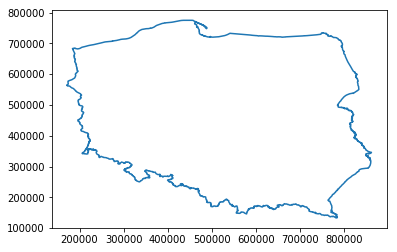

In [7]:
# You may test this class and its methods with vector file of Poland. It is stored in
# data/vector/Polska.shp file

# First read file by the class constructor and get all parameters of this file then show it

poland = 'data/vector/Polska.shp'
vector_poland = VectorData(poland)
vector_poland.get_vector_data()
vector_poland.show_vector_data()

In [8]:
# Read CRS of this data

vector_poland.vec_crs

{'ellps': 'GRS80',
 'k': 0.9993,
 'lat_0': 0,
 'lon_0': 19,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 500000,
 'y_0': -5300000}

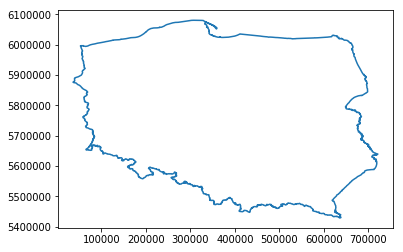

In [9]:
# Change crs and projection to the epsg:32634 and save it to the new variable
# Do not overwrite actual CRS
# Show the new geometry

epsg = 32634
changed_crs = vector_poland.reproject_geometry(epsg, update=False)
vector_poland.show_vector_data(changed_crs)

In [10]:
# Prepare new function to get the epsg number from Landsat raster. Use rasterio.open method.
# You shouldn't read whole raster, if you use rasterio.open to get the Landsat file
# then you may read only its crs. You will get dict CRS({'init': 'epsg:32634'})
# EPSG is a number after epsg: string (32634) and this should be returned by the function

def get_epsg_from_raster(raster_address):
    """Function reads raster data and gets its coordinate reference system.
    Then it is converted to the European Petroleum Survey Group (EPSG) reference number.
    Function was tested only with the Landsat rasters."""
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg

In [11]:
landsat_images = read_landsat_images(algal_blooms.landsat_dataframe['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

In [12]:
# Now you have the epsg number and you know how to reproject vector geometry.
# Now is the time to prepare area of interest for the further study. Read file 
# zatoka_gdanska.shp and prepare its geometry.
# Do not reproject this file yet. Try to use function clip_area:
# clip_area(vector_data.geometry, address_to_landsat_image, output_filename.tif)
# Read the error returned by rasterio. It is important to understand these errors.

filename = 'data/vector/zatoka_gdanska.shp'
gdansk_bay = VectorData(filename)
gdansk_bay.get_vector_data()
clip_area(gdansk_bay.geometry, landsat_images[1], 'data/failed_test.tif')

--- Object geometry, properties, crs and schema updated ---


ValueError: Input shapes do not overlap raster.

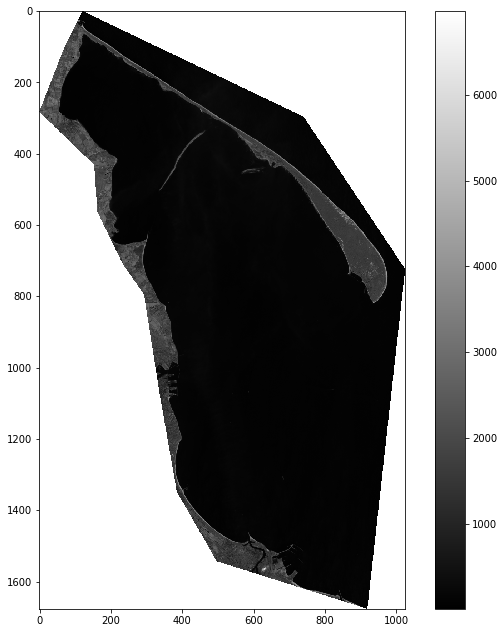

In [13]:
# Now reproject vector geometry and try to clip raster area to the new file with updated geometry
# You may overwrite data (vector file)
# Save clipped file as a "test.tif"
# Show "test.tif". Read file with rasterio.open and show band with show_band() function.

gdansk_bay.reproject_geometry(epsg, update=True)
clip_area(gdansk_bay.geometry, landsat_images[5], 'data/test.tif')
with rio.open('data/test.tif', 'r') as test_file:
    band = test_file.read(1)
    show_band(band)

In [14]:
# Now you know how to prepare single band for analysis.
# The next step is to make process automatic so you cannot write functions for each raster.
# Maybe you've noticed that Landsat has many bands - we will use only few of them so your
# method should include this fact.
# Below is an example of implementation. Explanations for this implementation are presented
# in the article.

def clip_all(dataset, clipping_vector, bands=(2, 3, 4), folder_name='clipped/'):
    """Function performs clipping of all Landsat 8 bands given in the DIR column of the df parameter.
    input 1: dataset - dataframe with DIR column where each record points to the directory with a Landsat bands
    input 2: clipping_vector - vector geometry which is used as a area of interest
    input 3: bands=(2, 3, 4) - tuple of bands which should be clipped. Bands 2, 3, 4 are used for the BGR image creation.
    input 4: folder_name='clipped/' - directory where all clipped bands should be stored.
    
    output: [correct, damaged] - list of dicts with keys (dates) and values - correct images
    and damaged images. Damaged images were not process and they not exist in the destination folder."""
    
    data_range = len(dataset)
    damaged = {}
    correct = {}
    for i in range(0, data_range):
        date_str = dataset.index[i]
        images = read_landsat_images(dataset['DIR'][i])
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(clipping_vector, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                try: 
                    damaged[date_str].append(filename)
                except KeyError:
                    damaged[date_str] = [filename]
                pass
            
            # Check file
            try: 
                damaged[date_str]
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            except KeyError:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    try: 
                        correct[date_str].append(filename)
                    except KeyError:
                        correct[date_str] = [filename]
    return [correct, damaged]

In [15]:
# Prepare tuple of bands and clip multiple files with this tuple

my_bands = (1, 2, 3, 4, 5)  # bands for EVI, Kab1 and Kab2 calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(algal_blooms.landsat_dataframe,
                          gdansk_bay.geometry, 
                          my_bands,
                          my_folder_name)

File: data/clipped/LC_band1_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band3_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band1_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band3_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band1_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band3_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band1_2013-06-18.tif saved successfully
File: da

In [17]:
# Prepare pandas DataFrame from generated dict - take into account only correct values and dates
# index row = dates.
# Use method pandas.DataFrame.from_dict()

geo_df = pd.DataFrame.from_dict(prepared_files[0], orient='index')
geo_df.head()

,0,1,2,3,4
2013-04-15,data/clipped/LC_band1_2013-04-15.tif,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band3_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif
2013-05-01,data/clipped/LC_band1_2013-05-01.tif,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band3_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif
2013-05-17,data/clipped/LC_band1_2013-05-17.tif,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band3_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif
2013-06-18,data/clipped/LC_band1_2013-06-18.tif,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band3_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif
2013-08-05,data/clipped/LC_band1_2013-08-05.tif,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band3_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif


In [18]:
# Prepare function to calculate EVI index, kab1 index and kab2 index

# EVI is calculated as (bands numbers in square brackets):
# evi = 2.5 * ([B5] - [B4]) / ([B5] + 6 * [B4] - 7.5 * [B2] + 1)
# equation above derived from: 
# https://landsat.usgs.gov/sites/default/files/documents/si_product_guide.pdf
# EVI should be scaled by the factor of 0.00001
# EVI must be in a range between -1 and 1

# Kab1 is calculated as (bands numbers in square brackets):
# kab1 = 1.67 - 3.94 * ln[B2] + 3.78 * ln[B3]
# You should be prepared for zeros and negative values (you are using logarithm here)

# Kab2 is calculated as (bands numbers in square brackets):
# kab2 = 6.92274 - 5.7581 * (ln[B1] / ln[B3])
# You should be prepared for zeros and negative values (you are using logarithm here)

# Kab1 and Kab2 are derived from: Kabbara, N., J. Benkhelil, M. Awad, and V. Barale. 2008. 
# Monitoring water quality in the coastal area of Tripoli (Lebanon) using high-resolution 
# satellite data. ISPRS Journal of Photogrammetry and Remote Sensing 63:488–495

def select_bands(numbers, all_bands):
    selected_bands = []
    for number in numbers:
        band_desc = 'LC_band' + str(number) + '_'
        for band_name in all_bands:
            if type(band_name) is not str:
                pass
            else:
                if band_desc in band_name:
                    selected_bands.append(band_name)
    selected_bands.sort()
    return selected_bands

def calculate_indicator(bands, indicator):
    """Function calculates chosen indicator from given data and returns it as 
    a map (numpy array)"""
    if indicator == 'evi':
        bands = select_bands([2, 4, 5], bands)
        
        with rio.open(bands[2]) as a:
            nir_band = (a.read()[0]/10000).astype(np.float)
        with rio.open(bands[1]) as b:
            r_band = (b.read()[0]/10000).astype(np.float)
        with rio.open(bands[0]) as c:
            b_band = (c.read()[0]/10000).astype(np.float)
        
        numerator = nir_band - r_band
        g = 2.5
        c1 = 6
        c2 = 7.5
        l = 1
        denominator = nir_band + c1 * r_band - c2 * b_band + l
        evi = g * (numerator / denominator)
        evi[evi > 1] = 1
        return evi
        
    elif indicator == 'kab1':
        # 1.67 - 3.94 * ln(B2) + 3.78 * ln(B3)
        bands = select_bands([2, 3], bands)
        
        with rio.open(bands[0]) as a:
            blue_band = (a.read()[0]).astype(np.float)
            blue_band[blue_band < 0] = 0
        with rio.open(bands[1]) as b:
            green_band = (b.read()[0]).astype(np.float)
            green_band[green_band < 0] = 0
        
        log_blue = np.log1p(blue_band)
        log_green = np.log1p(green_band)
        kab1 = 1.67 - 3.94 * log_blue + 3.78 * log_green
        return kab1
    
    elif indicator == 'kab2':
        # 6.92274 - 5.7581 * (ln(B1)/ln(B3))
        bands = select_bands([1, 3], bands)
        
        with rio.open(bands[0]) as a:
            ultra_blue_band = (a.read()[0]).astype(np.float)
            ultra_blue_band[ultra_blue_band < 0] = 0
        with rio.open(bands[1]) as b:
            green_band = (b.read()[0]).astype(np.float)
            green_band[green_band < 0] = 0
        
        log_blue = np.log1p(ultra_blue_band)
        log_green = np.log1p(green_band)
        kab2 = 6.92274 - 5.7581 * (log_blue / log_green)
        return kab2
    
    else:
        info = 'Your indicator {} is not implemented. Available indices: evi, Kab1, Kab2'.format(
        indicator)
        raise ValueError(info)